In [1]:
# !wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

In [2]:
import pandas as pd

df = pd.read_csv("jamb_exam_results.csv")

df.columns = df.columns.str.lower().str.replace(' ', '_')

In [3]:
df = (
    df
    .drop(columns="student_id")     # Remove the student_id column.
    .fillna(0)                      # Fill missing values with zeros.
)

In [4]:
from sklearn.model_selection import train_test_split

# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [5]:
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train["jamb_score"]
del df_val["jamb_score"]
del df_test["jamb_score"]

In [6]:
from sklearn.feature_extraction import DictVectorizer

# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
dv = DictVectorizer(sparse=False)

In [7]:
train_dicts = df_train.to_dict(orient="records")
val_dicts = df_val.to_dict(orient="records")

In [8]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score


dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [10]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- class: 118
|--- study_hours_per_week >  18.50
|   |--- class: 190



## Question 2

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
# rf.predict(X_val).score



RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
y_pred = rf.predict(X_val)

(((y_pred - y_val)**2).mean())**0.5

np.float64(42.13724207871227)

## Question 3

In [18]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = (((y_pred - y_val)**2).mean())**0.5
    scores.append((n, round(rmse, 3)))

In [19]:

df_scores = pd.DataFrame(data=scores, columns=["n_estimators", "rmse"])

df_scores.assign(
    diff=df_scores.rmse.diff()
)

,n_estimators,rmse,diff
0,10,42.137,NaN
1,20,41.461,-0.676
2,30,41.106,-0.355
3,40,40.917,-0.189
4,50,40.852,-0.065
5,60,40.784,-0.068
6,70,40.677,-0.107
7,80,40.539,-0.138
8,90,40.504,-0.035
9,100,40.517,0.013


## Question 4

In [23]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=d, n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = (((y_pred - y_val)**2).mean())**0.5
        scores.append((d, n, rmse))

df_scores = pd.DataFrame(data=scores, columns=["max_depth", "n_estimators", "rmse"])

In [25]:
df_scores.groupby(by="max_depth")["rmse"].mean().sort_values(ascending=True)

max_depth
10    40.392498
15    40.735282
20    40.739734
25    40.787866
Name: rmse, dtype: float64

## Question 5

In [45]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


pd.DataFrame(index=dv.feature_names_, data=rf.feature_importances_, columns=["feature importance"]).sort_values(by="feature importance", ascending=False)

,feature importance
study_hours_per_week,0.248354
attendance_rate,0.149729
distance_to_school,0.136486
teacher_quality,0.082682
age,0.069311
assignments_completed,0.031517
socioeconomic_status=High,0.025714
parent_involvement=High,0.022919
it_knowledge=High,0.017719
parent_education_level=Secondary,0.016957


## Question 6

In [46]:
import xgboost as xgb

features = dv.feature_names_

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [56]:
def parse_xgb_output(output):
    return (
        pd.DataFrame([line.split("\t") for line in output.stdout.split("\n")][:-1])
        .assign(
            num_iter=lambda df_: df_[0].str.strip("[]"),
            train_auc=lambda df_: df_[1].str.split(":", expand=True)[1],
            val_auc=lambda df_: df_[2].str.split(":", expand=True)[1],
        )
        .astype({
            "num_iter": int,
            "train_auc": float,
            "val_auc": float,
        })
        .drop(columns=[0, 1, 2])
    )

In [60]:
%%capture output

watchlist = [(dtrain, "train"), (dval, "val")]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=5)

In [61]:
df_score = parse_xgb_output(output)
df_score.tail(1)

,num_iter,train_auc,val_auc
20,99,11.56417,44.4321


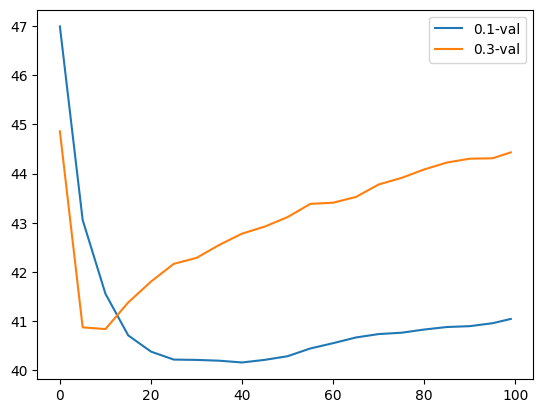

In [66]:
import matplotlib.pyplot as plt

plt.plot(df_score_1.num_iter, df_score_1.val_auc, label="0.1-val")
plt.plot(df_score_3.num_iter, df_score_3.val_auc, label="0.3-val")
plt.legend()

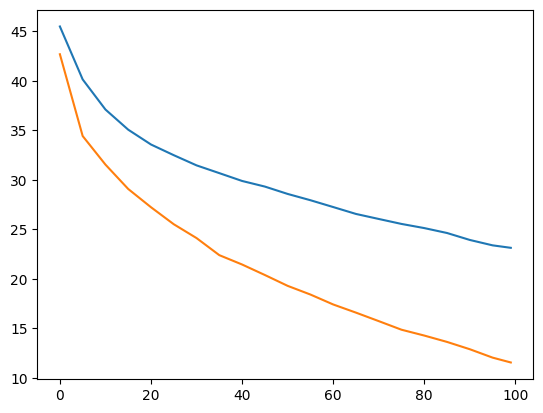

In [67]:
plt.plot(df_score_1.num_iter, df_score_1.train_auc, label="0.1-train")
plt.plot(df_score_3.num_iter, df_score_3.train_auc, label="0.3-train")